# Lifesurance: An Insurance Cost Predictor

This is the Jupyter notebook of the machine learning implementation of Lifesurance from capstone project group B21-CAP0134 (Agrilogi). You can replicate the model that we've created by following along and running the code cells in this notebook.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

## Data

You can download the CSV [here](https://www.kaggle.com/mirichoi0218/insurance) and then upload it to this notebook. The CSV dataset will be read into a Pandas dataframe.

In [ ]:
dataframe = pd.read_csv("/content/insurance.csv")

### Describe data, missing values, data types

There are six features in this dataset: age, sex, BMI (body mass index), children, smoker, and region. Charges is the target variable. Here we can see that the variables have different ranges of numbers, and we're going to work on that later.

In [ ]:
display(dataframe.head())
display(dataframe.describe())
display(dataframe.isna().any())
print("Data Types:")
display(dataframe.dtypes)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

Data Types:


age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In this plot we can analyze the correlation of every pair of variables

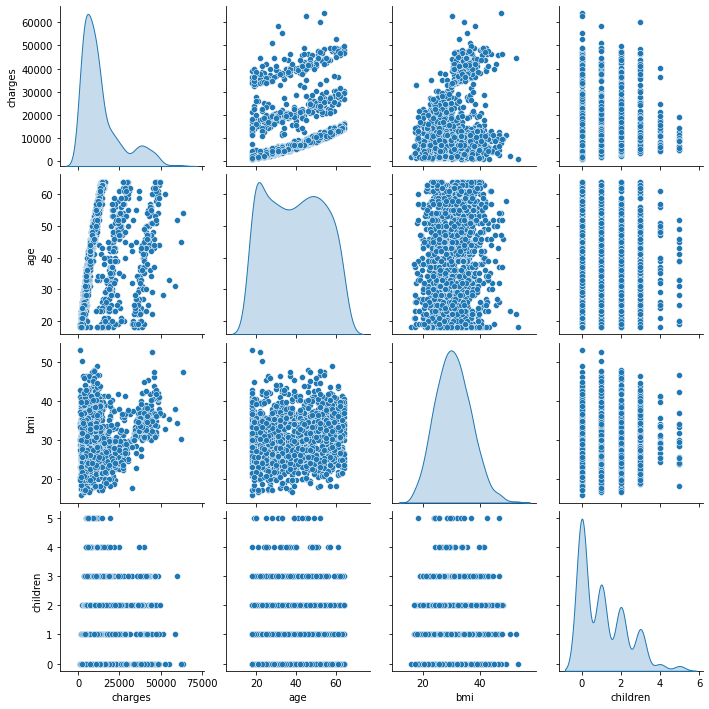

In [ ]:
sns.pairplot(dataframe[['charges', 'age', 'bmi', 'children']], diag_kind='kde')

### Target variable

Neural networks tend to perform better on small numbers, so the target variable is divided by 1000 to bring down the numbers from thousands and ten thousands to ones and tens.

In [ ]:
dataframe['target'] = dataframe['charges']
dataframe = dataframe.drop(columns=['charges'])

dataframe['target'] = dataframe['target'] / 1000
dataframe.head()

,age,sex,bmi,children,smoker,region,target
0,19,female,27.900,0,yes,southwest,16.884924
1,18,male,33.770,1,no,southeast,1.725552
2,28,male,33.000,3,no,southeast,4.449462
3,33,male,22.705,0,no,northwest,21.984471
4,32,male,28.880,0,no,northwest,3.866855


### Split data

The data is split into train, val, and test sets with ratio of 8:1:1 respectively.

In [ ]:
train, test = train_test_split(dataframe, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

1083 train examples
121 validation examples
134 test examples


### Feature columns

As for the features, children is left as numerical value because the number is already small. Age and BMI are bucketized or binned to 20, 30, 40, and 50 boundaries and will have a one-hot encoding form. Meanwhile, sex, region, and smoker will be transformed into categorical variables.

In [ ]:
feature_columns = []

# numeric cols
feature_columns.append(feature_column.numeric_column('children'))
# bucketized cols
age = feature_column.numeric_column('age')
age_buckets = feature_column.bucketized_column(age, boundaries=[20, 30, 40, 50])
feature_columns.append(age_buckets)

bmi = feature_column.numeric_column('bmi')
bmi_buckets = feature_column.bucketized_column(bmi, boundaries=[20, 30, 40, 50])
feature_columns.append(bmi_buckets)

# indicator cols (categorical)
indicator_column_names = ['sex', 'region', 'smoker']
for col_name in indicator_column_names:
  unique = dataframe[col_name].unique()
  display(unique)
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, unique)
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

array(['female', 'male'], dtype=object)

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

array(['yes', 'no'], dtype=object)

### To TF dataset

The pandas DataFrame is then converted into a TF dataset so it can be fed into the model. The dataset is shuffled (training only) and batched into 64-sized batches.

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Create, compile, train model

### Learning rate test

The model consists of a number of layers:
1. Feature layer that we made earlier,
2. Lambda layer that expands the feature dimension so that it can go into the 1D convolutional layer
3. The 1D Convolutional layer with 16 filters and kernel size of 5
4. Flatten layer
5. Couple of dense layers with units of 128 and 64 respectively
6. Last dense layer which is the regressor layer that outputs the predicted medical cost (charge)

Adam optimizer is used with `1e-4` learning rate and MAE is used as the loss function. The model then gets trained for 300 epochs.

In [ ]:
model = tf.keras.Sequential([
    feature_layer,
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),
    tf.keras.layers.Conv1D(16, 5),
    tf.keras.layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='mae',
              optimizer=optimizer)
history = model.fit(train_ds, validation_data=val_ds, epochs=300)

Epoch 1/300
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
13/17 [=====================>........] - ETA: 0s - loss: 13.2799WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'sex': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'bmi': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=float64>, 'children': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=int64>, 'smoker': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'region': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
17/17 [==============================] - 1s 18ms/step - loss: 13.1253 - val_loss: 14.3401
Epoch 2/300
17/17 [==============================] - 0s 6ms/step - loss: 12.8359 - val_loss: 14.0474
Epoch 3/300
17/17 [=================

Here is the summary of the model arhictecture.

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
lambda_1 (Lambda)            multiple                  0         
_________________________________________________________________
conv1d_1 (Conv1D)            multiple                  192       
_________________________________________________________________
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_9 (Dense)              multiple                  61568     
_________________________________________________________________
dense_10 (Dense)             multiple                  8256      
_________________________________________________________________
dense_11 (Dense)             multiple                 

Here we can analyze the loss plot. Both training loss and validation loss descend nicely.

<Figure size 432x288 with 0 Axes>

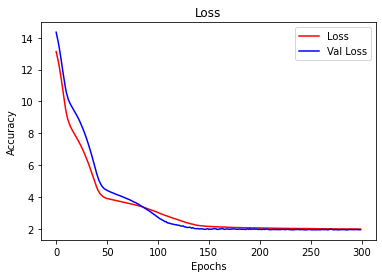

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

loss=history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Val Loss"])

plt.figure()

If we zoom in a little bit into the plot, we can see that the validation loss has started to stagnate at just below 2.0 of MAE.

<Figure size 432x288 with 0 Axes>

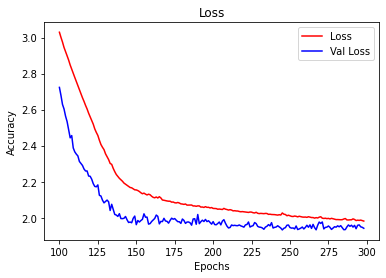

<Figure size 432x288 with 0 Axes>

In [ ]:
left_bound = 100
right_bound = -1

epochs_zoom = epochs[left_bound:right_bound]
loss_zoom = loss[left_bound:right_bound]
val_loss_zoom = val_loss[left_bound:right_bound]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, loss_zoom, 'r')
plt.plot(epochs_zoom, val_loss_zoom, 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Loss", "Val Loss"])

plt.figure()

Lastly, we will check the performance on the test set.

In [ ]:
pred = model.predict(test_ds)

Consider rewriting this model with the Functional API.


The mean absolute error on the test set is at 1.56. That means the predicted medical charge on average have confidence interval of about 1560 US dollars more or less than the predicted value.

In [ ]:
from sklearn import metrics
np.sqrt(metrics.mean_absolute_error(pred, test['target']))

1.5602615799178

## Save Model

The finished model can then be saved into HDF5 format to be served in the cloud.

In [ ]:
from google.colab import files

filename = '/content/insurance_dnn.h5'
model.save(filename)
files.download(filename)